In [1]:
import pandas as pd
import numpy as np
import requests
import json
from tqdm import tqdm_notebook, tqdm
import re
%pylab inline
from sklearn.metrics import accuracy_score, f1_score

Populating the interactive namespace from numpy and matplotlib


In [79]:
from itertools import zip_longest

def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

Загрузим размеченные клиентские сообщения и приведем разметку к единому формату

In [80]:
samples = pd.read_csv('samples_from_client_mes.csv', 
                      encoding='mac_cyrillic', 
                      delimiter=';', 
                      names=['mes', 'score'], 
                     skiprows=1)
samples.score.fillna(value=3, inplace=True)
samples.score.replace(to_replace={'полож':5, 'отриц':1, "п":5, "о":1}, inplace=True)
samples.mes = samples.mes.str.replace('& amp, quo,', '')
samples.head()

,mes,score
0,Ок. .. Пошел почитаю. .. С утром вас. .. Светит,3
1,"Хорошо, вклад хочу открыть под максимальную ст...",3
2,Хочу вклад открыть под максимальную ставку,3
3,как я открыть могу открыть брокерский счет ?,3
4,как я открыть могу открыть брокерский счет ?,3


Столбцы с бинарными метками (принадлежит классу или нет)

In [4]:
samples['score_5_vs_all'] = samples.score == 5
samples['score_1_vs_all'] = samples.score == 1

In [5]:
samples.head()

,mes,score,score_5_vs_all,score_1_vs_all
0,Ок. .. Пошел почитаю. .. С утром вас. .. Светит,3,False,False
1,"Хорошо, вклад хочу открыть под максимальную ст...",3,False,False
2,Хочу вклад открыть под максимальную ставку,3,False,False
3,как я открыть могу открыть брокерский счет ?,3,False,False
4,как я открыть могу открыть брокерский счет ?,3,False,False


In [6]:
samples.score.value_counts(dropna=False)

3    14964
5      637
1       95
Name: score, dtype: int64

Получим вероятности принадлежности к каждому из классов

In [7]:
scores = []
#num_samples = 15000
source = 'foursquare.com'
for mes in tqdm_notebook(grouper(samples['mes'].values, 2000)):
    data = {'text':mes, 'source':source}
    res = requests.post(url='http://0.0.0.0:5000/api/proba', data=data)
    try:
        score = res.json()['proba']
        score = np.array(score)
        scores.append(score)
        #sentiments_fsq[i] = score
    except:
        print('fail')
        continue
scores_np = np.vstack(scores)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Построим бинарный классификатор для метки 5 и посмотрим на f1 при различных порогах

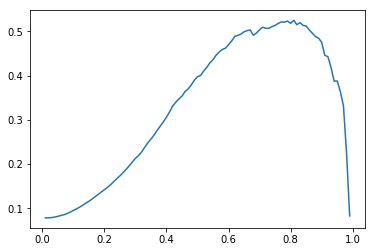

In [9]:
thresholds = arange(0.01, 1, 0.01)
f1_scores = []
for thr in thresholds:
    is_5 = scores_np[:, 2] > thr
    f1 = f1_score(samples.score_5_vs_all.values, is_5)
    f1_scores.append(f1)
    #print(thr, f1)
plot(thresholds, f1_scores)
best_t_5 = thresholds[argmax(f1_scores)]

Аналогично для метки 1

/Users/ak/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


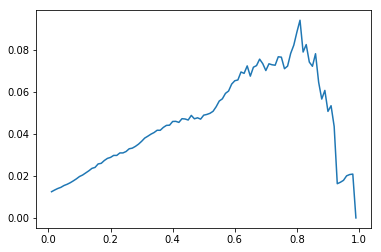

In [10]:
f1_scores = []
for thr in thresholds:
    is_1 = scores_np[:, 0] > thr
    f1 = f1_score(samples.score_1_vs_all.values, is_1)
    f1_scores.append(f1)
    #print(thr, f1)
plot(thresholds, f1_scores)
best_t_1 = thresholds[argmax(f1_scores)]

In [11]:
best_t_1, best_t_5

(0.81, 0.81)

In [12]:
scores_np.max(axis=1).min()

0.3351140022277832

Попробуем классифицировать по максимальной вероятности

In [13]:
mapping = {0:1, 1:3, 2:5}
am = argmax(scores_np, axis=1)
am_score = [mapping[i] for i in am]

In [15]:
accuracy_score(samples.score.values, am_score), f1_score(samples.score.values, am_score, average='macro')

(0.7542686034658511, 0.42038268015147967)

In [39]:
pos = samples[samples.score == 5]
neg = samples[samples.score == 1]
neut = samples[samples.score == 3]

In [20]:
scores = []
source = 'foursquare.com'
for mes in tqdm_notebook(grouper(samples['mes'].values, 100)):
    data = {'text':mes, 'source':source}
    res = requests.post(url='http://0.0.0.0:5000/api/proba', data=data)
    try:
        score = res.json()['proba']
        score = np.array(score)
        scores.append(score)
        #sentiments_fsq[i] = score
    except:
        print('fail')
        continue
scores_np = np.vstack(scores)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Получим вероятности каждой тональности для сообщений с позитивной тональностью

In [40]:
scores = []
source = 'foursquare.com'
for mes in tqdm_notebook(grouper(pos['mes'].values, 100)):
    data = {'text':mes, 'source':source}
    res = requests.post(url='http://0.0.0.0:5000/api/proba', data=data)
    try:
        score = res.json()['proba']
        score = np.array(score)
        scores.append(score)
        # sentiments_fsq[i] = score
    except:
        print('fail')
        continue
scores_np = np.vstack(scores)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Построим распределение вероятностей для каждой тональност

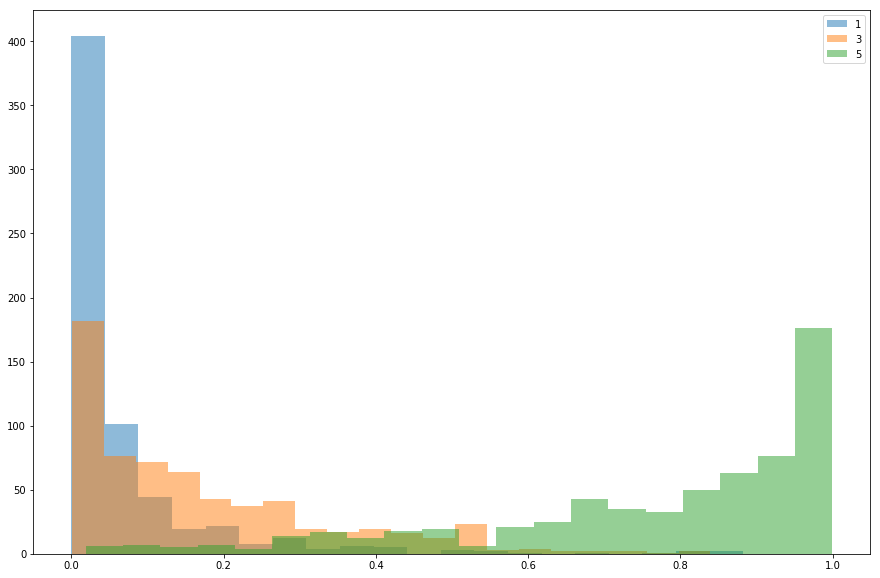

In [41]:
plt.figure(figsize=(15,10))
for i in range(scores_np.shape[1]):
    hist(scores_np[:, i], alpha=0.5, bins=20)
legend(['1', '3', '5'])

Аналогично проделаем для сообщений с негативной тональностью

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

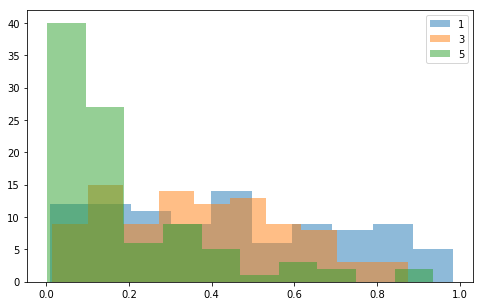

In [42]:
scores = []
source = 'foursquare.com'
for mes in tqdm_notebook(grouper(neg['mes'].values, 100)):
    data = {'text':mes, 'source':source}
    res = requests.post(url='http://0.0.0.0:5000/api/proba', data=data)
    try:
        score = res.json()['proba']
        score = np.array(score)
        scores.append(score)
        #sentiments_fsq[i] = score
    except:
        print('fail')
        continue
scores_np = np.vstack(scores)
plt.figure(figsize=(8,5))
for i in range(scores_np.shape[1]):
    hist(scores_np[:, i], alpha=0.5, bins=10)
legend(['1', '3', '5'])

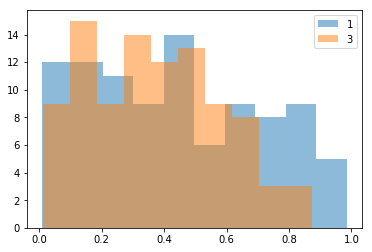

In [43]:
hist(scores_np[:, 0], alpha=0.5, bins=10)
hist(scores_np[:, 1], alpha=0.5, bins=10)
legend(['1','3'])

In [46]:
neg.head(60)

,mes,score,score_5_vs_all,score_1_vs_all
24,Отлично. Потерял карту. А пин-код изменится ?,1,False,True
456,"Как плохо, а они тогда как быстро сгорают ?",1,False,True
888,не один из предложенных вариантов не подошёл,1,False,True
899,Не могу совершить покупки в интернете через карту,1,False,True
1067,"А потом вы берете и отказываете, где логика ?",1,False,True
2275,У меня банкомат карту захватил. Что мне делать,1,False,True
2519,Жаль. .. а его можно как-то получить ? ) ),1,False,True
2812,Отказал мне предоставить личный номер и нес чушь,1,False,True
3133,"Спасибо, за зря потраченное время. Досвиданье",1,False,True
3284,Я # Name заявку для вашего приложения и нет от...,1,False,True


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

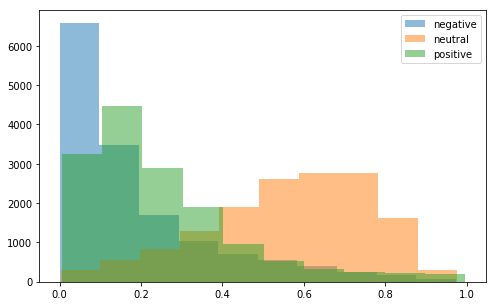

In [45]:
scores = []
source = 'foursquare.com'
for mes in tqdm_notebook(grouper(neut['mes'].values, 1000)):
    data = {'text':mes, 'source':source}
    res = requests.post(url='http://0.0.0.0:5000/api/proba', data=data)
    try:
        score = res.json()['proba']
        score = np.array(score)
        scores.append(score)
        #sentiments_fsq[i] = score
    except:
        print('fail')
        continue
scores_np = np.vstack(scores)
plt.figure(figsize=(8,5))
for i in range(scores_np.shape[1]):
    hist(scores_np[:, i], alpha=0.5, bins=10)
legend(['negative', 'neutral', 'positive'])

In [181]:
scores_np = np.vstack(scores)

In [153]:
y_true = ones_like(scores) * 5
accuracy_score(y_true, scores), f1_score(y_true, scores, average=None)

/Users/ak/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0.5232198142414861, array([0.        , 0.        , 0.68699187]))

In [90]:
texts = ['Спасибо', 'пожалуйста', 'отстой']
source = 'foursquare.com'
#data = [{'text':t, 'source':source} for t in texts]
data = {'text':texts, 'source':source}

In [109]:
df.dropna(inplace=True)
df.drop_duplicates(subset=['mes'], inplace=True)

In [119]:
xx = range(100)
scores = []
for mes in tqdm_notebook(grouper(df.mes.values, 2000)):
    data = {'text':mes, 'source':source}
    res = requests.post(url='http://0.0.0.0:5000/api/score', data=data)
    try:
        score = res.json()['score']
        scores.append(score)
        #sentiments_fsq[i] = score
    except:
        print('fail')
        continue

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Exception in thread Thread-11:
Traceback (most recent call last):
  File "/Users/ak/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/ak/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/ak/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



KeyboardInterrupt: 

In [94]:
res = requests.post(url='http://0.0.0.0:5000/api/score', data=data)

In [97]:
res.json()['score']

[5, 3, 1]

In [105]:
df = pd.read_csv('Client_messages_cleaned.csv', 
                 encoding='cp1251', 
                 delimiter=';', 
                 names=['cnt', 'mes'])
df.head()

,cnt,mes
0,2,"Я внес деньги на карту. Когда они придут, я их..."
1,4,Кредитная
2,6,По карте
3,8,Да
4,10,Да


In [13]:
sentiments_fsq = np.zeros(len(df))
for i, mes in tqdm_notebook(enumerate(df.mes.values)):
    if not isinstance(mes, str):
        continue
    if not re.search('\w+', mes):
        continue
    data = {'text':mes, 'source':'foursquare.com'}
    # data = {'text':mes, 'source':'other'}
    res = requests.post(url='http://0.0.0.0:5000/api/score', data=data)
    try:
        score = res.json()['score']
        sentiments_fsq[i] = score
    except:
        print('fail')
        continue

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/Users/ak/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/Users/ak/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/ak/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail



In [21]:
sentiments = np.zeros(len(df))
cnt = 0
messages = df.mes.values
i=0
for mes in tqdm_notebook(messages):
    if not isinstance(mes, str):
        continue
    if not re.search('\w+', mes):
        continue
    # data = {'text':mes, 'source':'foursquare.com'}
    data = {'text':mes, 'source':'other'}
    res = requests.post(url='http://0.0.0.0:5000/api/score', data=data)
    try:
        score = res.json()['score']
        sentiments[i] = score
    except:
        print('fail')
        cnt += 1
        continue
    i+=1
print('%i fails'%cnt)

HBox(children=(IntProgress(value=0, max=819752), HTML(value='')))

fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail
fail

139 fails


In [22]:
df['sentiments_other'] = sentiments

In [20]:
type(messages)

numpy.ndarray

In [23]:
df.to_csv('Client_mess_with_foursquare_model_sentiments.csv')

In [24]:
df.head()

,cnt,mes,sentiments_forsquare,sentiments_other
0,2,"Я внес деньги на карту. Когда они придут, я их...",3.0,3.0
1,4,Кредитная,5.0,3.0
2,6,По карте,3.0,3.0
3,8,Да,1.0,3.0
4,10,Да,1.0,3.0


In [27]:
df.corr(method='spearman')

,cnt,sentiments_forsquare,sentiments_other
cnt,1.000000,-0.012943,-0.017428
sentiments_forsquare,-0.012943,1.000000,0.004113
sentiments_other,-0.017428,0.004113,1.000000


In [2]:
df = pd.read_csv('Client_mess_with_foursquare_model_sentiments.csv')

In [3]:
df.head(20)

,Unnamed: 0,cnt,mes,sentiments_forsquare,sentiments_other
0,0,2,"Я внес деньги на карту. Когда они придут, я их...",3.0,3.0
1,1,4,Кредитная,5.0,3.0
2,2,6,По карте,3.0,3.0
3,3,8,Да,1.0,3.0
4,4,10,Да,1.0,3.0
5,5,17,"ООО, вас чат появился",5.0,3.0
6,6,19,Прикольное,5.0,5.0
7,7,21,А баланс можете сказать,1.0,3.0
8,8,22,"А нет, не надо",1.0,3.0
9,9,23,А до # Name вы работаете,3.0,3.0


In [8]:
df[df.sentiments_other==3]

,Unnamed: 0,cnt,mes,sentiments_forsquare,sentiments_other
0,0,2,"Я внес деньги на карту. Когда они придут, я их...",3.0,3.0
1,1,4,Кредитная,5.0,3.0
2,2,6,По карте,3.0,3.0
3,3,8,Да,1.0,3.0
4,4,10,Да,1.0,3.0
5,5,17,"ООО, вас чат появился",5.0,3.0
7,7,21,А баланс можете сказать,1.0,3.0
8,8,22,"А нет, не надо",1.0,3.0
9,9,23,А до # Name вы работаете,3.0,3.0
10,10,25,А где вы находитесь,3.0,3.0


In [10]:
df['length'] = df.mes.apply(lambda x: len(str(x)))

In [11]:
df.head()

,Unnamed: 0,cnt,mes,sentiments_forsquare,sentiments_other,length
0,0,2,"Я внес деньги на карту. Когда они придут, я их...",3.0,3.0,58
1,1,4,Кредитная,5.0,3.0,9
2,2,6,По карте,3.0,3.0,8
3,3,8,Да,1.0,3.0,2
4,4,10,Да,1.0,3.0,2


In [19]:
df[(df.sentiments_other==1) & (df['length'] >12)]

,Unnamed: 0,cnt,mes,sentiments_forsquare,sentiments_other,length
19,19,56,А на каком основании банк л наложи арест,1.0,1.0,40
33,33,104,До свидания .,3.0,1.0,13
57,57,173,Хотел бы больше узнать про вклад сохраняй. как...,1.0,1.0,106
66,66,208,Просто оператор говорила что должен быть какой...,1.0,1.0,61
118,118,358,"ООО, как круто : )",5.0,1.0,18
183,183,498,Погодка шепчет прямо,5.0,1.0,20
314,314,812,А преимущества какие ?,1.0,1.0,22
333,333,866,Здравствуйте. Я недавно оформил пакет услуг Пр...,5.0,1.0,81
339,339,887,Что такое Сбербанк Премьер ?,3.0,1.0,28
407,407,1097,"О, класс, пойду в офис",5.0,1.0,22


In [22]:
df.to_csv('client_mess_sentiment_length.csv', encoding='cp1251')

In [30]:
df1 = df[df['length'] > 150]
df1.to_excel('client_mess_sentiment_length.xls', encoding='cp1251')

In [31]:
df1.shape

(32160, 6)

In [55]:
upper = 25
lower = 20
df4 = df[(df['length'] <= upper) & (df['length'] > lower)]
if len(df4) < 65535:
    df4.to_excel('client_mess_sentiment_length_%i_%i.xls'%(lower, upper), encoding='cp1251')
else:
    print('Слишком длинный файл')

In [56]:
df4.shape

(39773, 6)

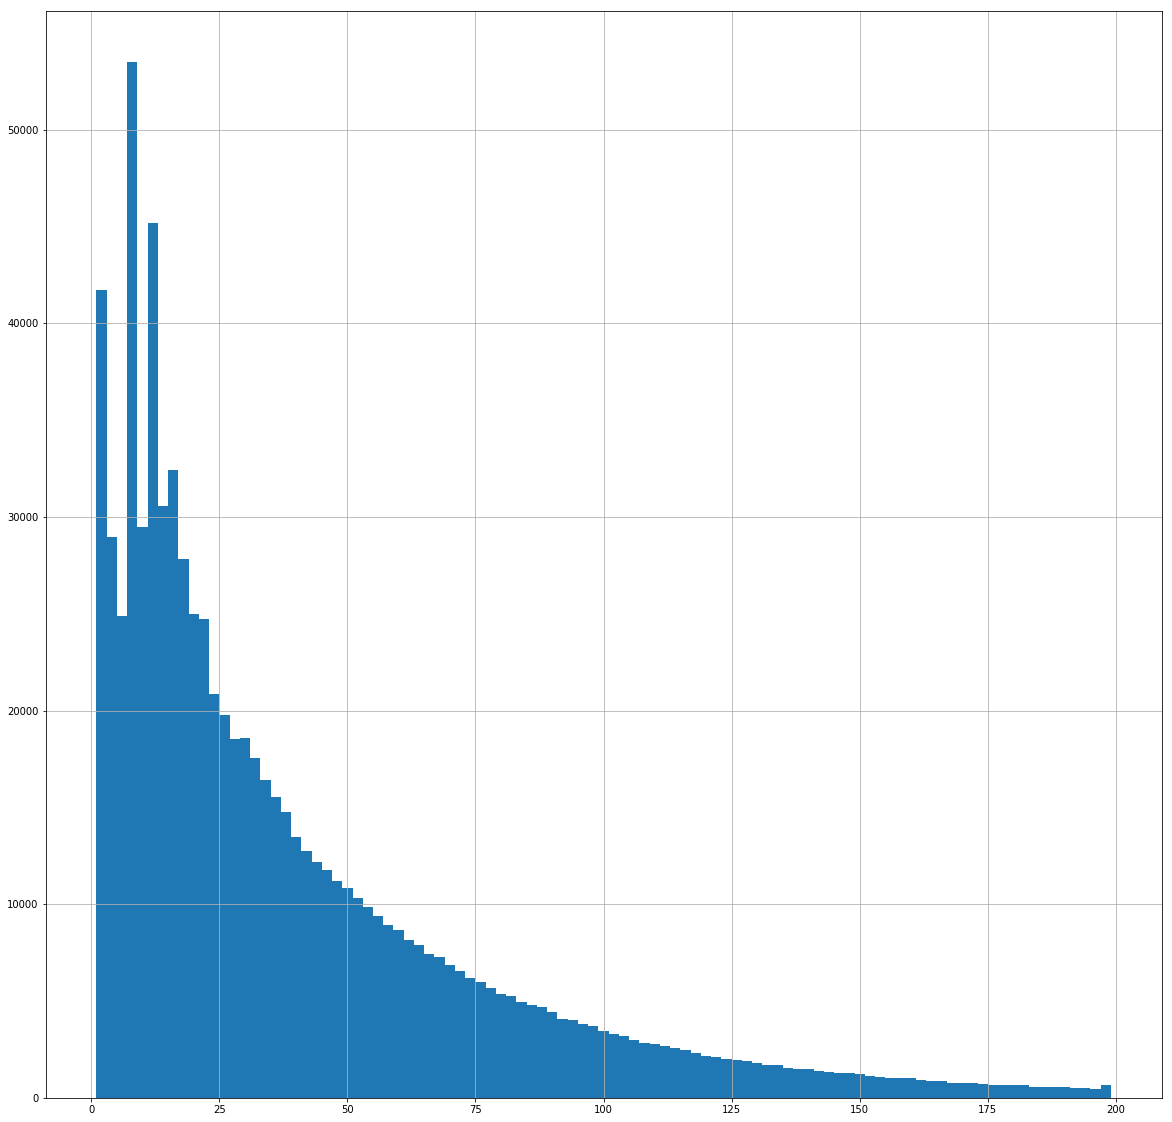

In [45]:
df[df['length'] < 200]['length'].hist(bins=99, figsize=(20,20))

In [47]:
df['mes'].value_counts().cumsum()

Спасибо                                                                                                                                            25834
Да                                                                                                                                                 50217
Здравствуйте                                                                                                                                       61636
спасибо                                                                                                                                            70618
да                                                                                                                                                 77876
Нет                                                                                                                                                84509
?                                                                                 

In [48]:
df.drop_duplicates(subset=['mes'], inplace=True)

In [49]:
df.shape

(524519, 6)

In [60]:
def get_num_words(s):
    if not isinstance(s, str):
        return 0
    x = re.findall('\w+', s)
    if x:
        return len(x)
    else:
        return 0

In [61]:
df['num_words'] = df.mes.apply(get_num_words)

In [62]:
df.head()

,Unnamed: 0,cnt,mes,sentiments_forsquare,sentiments_other,length,num_words
0,0,2,"Я внес деньги на карту. Когда они придут, я их...",3.0,3.0,58,12
1,1,4,Кредитная,5.0,3.0,9,1
2,2,6,По карте,3.0,3.0,8,2
3,3,8,Да,1.0,3.0,2,1
5,5,17,"ООО, вас чат появился",5.0,3.0,21,4


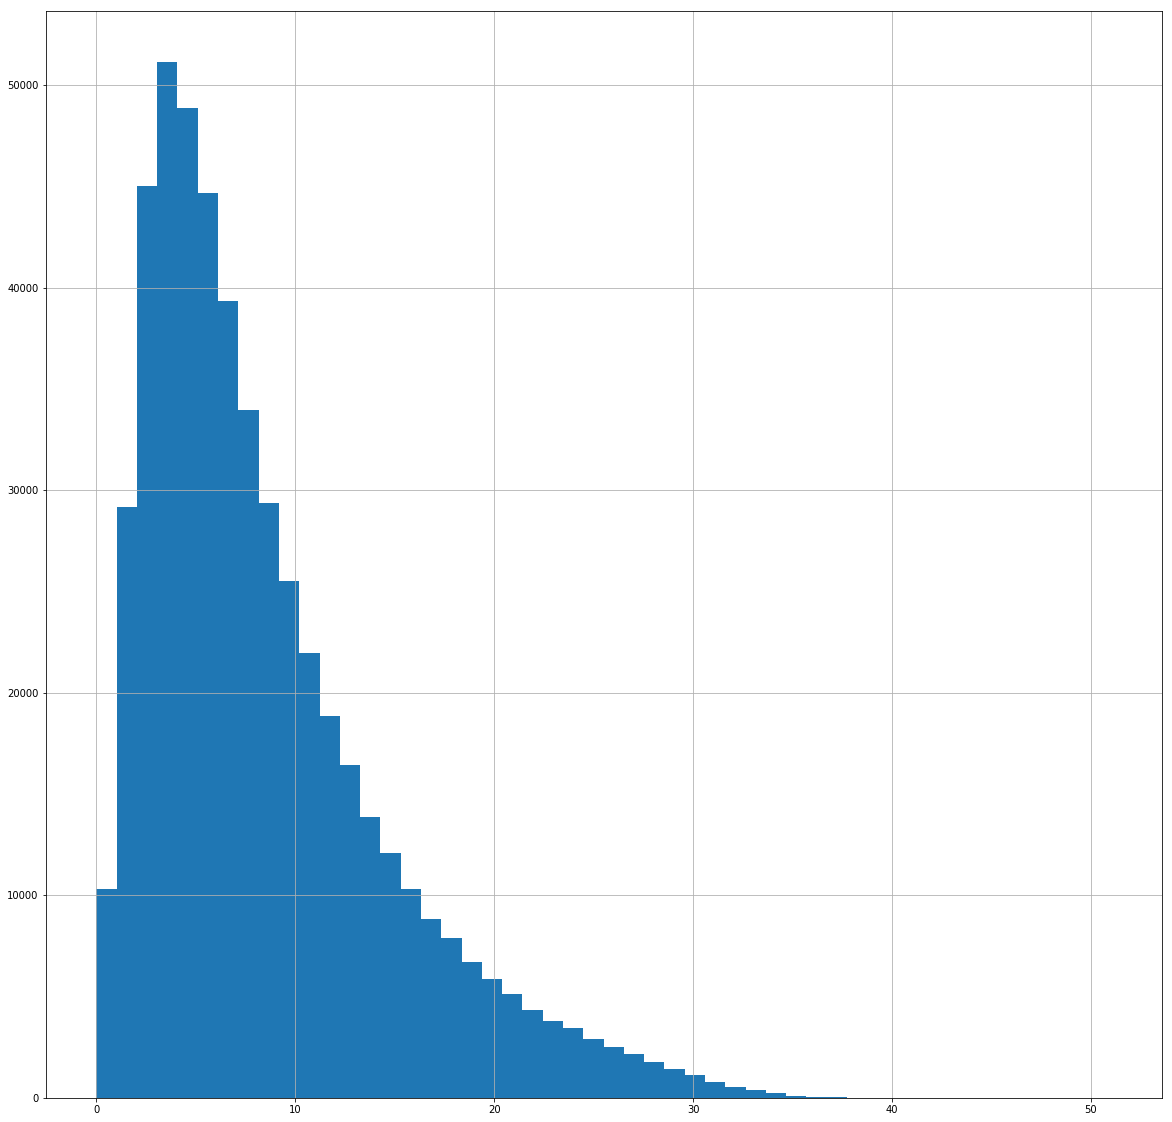

In [66]:
df[df['length'] < 200]['num_words'].hist(bins=50, figsize=(20,20))


In [50]:
df.sentiments_forsquare.value_counts()

1.0    194358
3.0    187969
5.0    141885
0.0       307
Name: sentiments_forsquare, dtype: int64

In [51]:
df.sentiments_other.value_counts()

3.0    386621
5.0    101958
1.0     26519
0.0      9421
Name: sentiments_other, dtype: int64

In [57]:
re.findall('\w+', 'sfd erw')

['sfd', 'erw']

In [67]:
from flask import request

In [70]:
r = request()

RuntimeError: Working outside of request context.

This typically means that you attempted to use functionality that needed
an active HTTP request.  Consult the documentation on testing for
information about how to avoid this problem.

In [2]:
(0.3 + 0.13) / 1.3

0.33076923076923076

In [33]:
import requests
import numpy as np
default_scores = [0.1563062220811844, 0.43191346526145935, 0.4117802679538727]
link = 'http://0.0.0.0:5000/api/proba'
data = {'text':'kufionuipo;iun', 'source':'foursquare.com'}
res = requests.post(url=link, data=data)
try:
    score = res.json()['proba']
    if np.allclose(score[0], default_scores, atol=1e-6):
        print('Слова неизвестны')
    else:
        print(score)
    #sentiments_fsq[i] = score
except:
    print('fail')

Слова неизвестны


In [8]:
import re
import pymystem3
import pandas as pd

class Is_obsc(object):
    def __init__(self, path_to_corpus):
        self.obsc = pd.read_csv(path_to_corpus, header=None)[0].values
        self.mstem = pymystem3.Mystem()
    
    def __call__(self, s):
        words = re.findall('\w+', s.upper())
        for w in words:
            # Приведение к нормальной форме
            a = self.mstem.analyze(w)
            a = a[0]['analysis'][0]['lex'].upper()
            print('Слово:', w, ', нормальная форма:', a)
            if (w in self.obsc) or (a in self.obsc):
                return True
        return False

In [9]:
is_obsc = Is_obsc('obscene_corpus.txt')

In [11]:
%%time
is_obsc('блджад')

Слово: БЛДЖАД , нормальная форма: БЛДЖАД
CPU times: user 569 µs, sys: 497 µs, total: 1.07 ms
Wall time: 957 µs


True

In [23]:
samples = pd.read_csv('samples_from_client_mes.csv', 
                      encoding='mac_cyrillic', 
                      delimiter=';', 
                      names=['mes', 'score'], 
                     skiprows=1)
samples.score.fillna(value=3, inplace=True)
samples.score.replace(to_replace={'полож':5, 'отриц':1, "п":5, "о":1}, inplace=True)
samples.mes = samples.mes.str.replace('& amp, quo,', '')
samples.head()

,mes,score
0,Ок. .. Пошел почитаю. .. С утром вас. .. Светит,3
1,"Хорошо, вклад хочу открыть под максимальную ст...",3
2,Хочу вклад открыть под максимальную ставку,3
3,как я открыть могу открыть брокерский счет ?,3
4,как я открыть могу открыть брокерский счет ?,3


In [19]:
import re
import pymystem3
import pandas as pd
import requests
import numpy as np
from itertools import zip_longest
from tqdm import tqdm

class Sentiment(object):
    """ path_to_corpus - путь к файлу с матерными словами
    link - ссылка на API
    default_scores - оценки нейросети в случае, если ни одно из слов ей не известно
    source - на чем обучалась модель (foursquare.com; other)
    batch_size - длина батча, подаваемого в нейросеть. Слишком малые значения замедляют выполнение
    так как требуется инициализация нейросети при каждом обращении
    """
    def __init__(self, path_to_corpus, link, 
                 default_scores = [0.156306222, 0.431913465, 0.411780267],
                source='foursquare.com', 
                batch_size=2000):
        self.obsc = pd.read_csv(path_to_corpus, header=None)[0].values
        self.mstem = pymystem3.Mystem()
        if link.endswith('/'):
            self.link = link
        else:
            self.link = link + '/'
        self.default_scores = default_scores # Оценки для случая, когда в строке нет ни одного слова, знакомого word2vec
        self.source = source
        self.batch_size = batch_size
    
    # Функция, позволяющая в цикле перебирать подмассивы по n значений вместо отдельных элементов
    def _grouper(self, iterable, n, fillvalue=None):
        args = [iter(iterable)] * n
        return zip_longest(*args, fillvalue=fillvalue)
    
    # Проверка, есть ли нецензурные выражения в фразе
    def is_obsc(self, s):
        words = re.findall('\w+', s.upper())
        for w in words:
            # Приведение к нормальной форме
            a = self.mstem.analyze(w)
            # try...except нужен, поскольку для некоторых слов анализ не проходит
            try:
                a = a[0]['analysis'][0]['lex'].upper()
                if (w in self.obsc) or (a in self.obsc):
                    return True
            except IndexError:
                print(w)
        return False
    
    def predict_proba(self, s):
        if not isinstance(s, (list, tuple)):
            s = list(s)
        scores = []
        n = min(self.batch_size, len(s))
        for mb in tqdm(self._grouper(s, n=n)):
            data = {'text':mb, 'source':self.source}
            res = requests.post(url=self.link + 'proba', data=data)
            score = res.json()['proba']
            scores.append(score)
        if scores:
            return np.vstack(scores)
    
    def predict(self, s):
        probas = self.predict_proba(s)
        #for mb in self._grouper(s, n=n):
        scores = np.zeros(len(s))
        for i in range(len(s)):
            scores[i] = 3
            if np.allclose(probas[i, :], self.default_scores, atol=1e-4):
                if self.is_obsc(s[i]):
                    scores[i] = 1
                    #print('матюги')
                else:
                    scores[i] = 3
                    #print('not known, not obscene')
            else:
                if probas[i, 2] > 0.5:
                    #print('>0.5')
                    scores[i] = 5
                elif (probas[i, 0] > 0.2) and (probas[i, 2] < 0.3):
                    # Критерий негатива: низкая вероятность позитива и не совсем маленькая вероятность негатива
                    #print('>0.1')
                    scores[i] = 1
                else:
                    #print('finally 3')
                    scores[i] = 3
        return scores
        

In [20]:
sentiment = Sentiment(path_to_corpus='obscene_corpus.txt', 
                     link = 'http://0.0.0.0:5000/api',
                     source='foursquare.com')

In [21]:
sentiment.predict(['привет!', 'иди нахуй', 'ты пидор', 'все отлично!'])

1it [00:00, 45.63it/s]


array([3., 1., 1., 5.])

In [30]:
source = 'foursquare.com'
from tqdm import tqdm_notebook
#for mes in tqdm_notebook(grouper(samples['mes'].values, 2000)):
scores = sentiment.predict_proba(samples['mes'].values)
#scores.append(score)
#scores_np = np.vstack(scores)
scores_np = np.array(scores)
print(scores_np.shape)

8it [00:23,  2.94s/it]

(15696, 3)


In [25]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
f1_score(samples.score.values, scores_np, average=None)

array([0.02934735, 0.75145084, 0.39748335])

In [26]:
precision_score(samples.score.values, scores_np, average=None)

array([0.01498546, 0.98951965, 0.26004843])

In [27]:
recall_score(samples.score.values, scores_np, average=None)

array([0.70526316, 0.6057204 , 0.84301413])

In [28]:
cm = confusion_matrix(samples.score.values, scores_np)
#print(cm / cm.sum(axis=1).reshape(-1, 1))
print(cm)

[[  67   21    7]
 [4379 9064 1521]
 [  25   75  537]]


In [104]:
len(samples[samples.score == 5])

637

In [178]:
is_5 = samples.score == 5
is_3 = samples.score == 3
is_1 = samples.score == 1

In [187]:
import matplotlib.pyplot as plt
%matplotlib inline

0.7855714377283507
0.897084651615608
0.9283370287231292


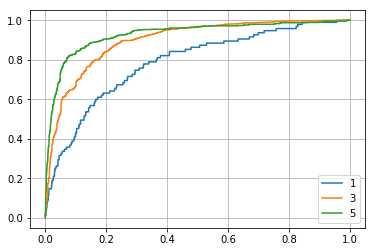

In [193]:
legend = []
for i, label in enumerate([1, 3, 5]):
    y_true = samples.score == label
    y_pred = scores_np[:, i]
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    #plt.figure()
    plt.plot(fpr, tpr)
    #plt.title('ROC ' + str(label))
    plt.grid()
    legend.append(str(label))
    print(roc_auc_score(y_true, y_pred))
plt.legend(legend)

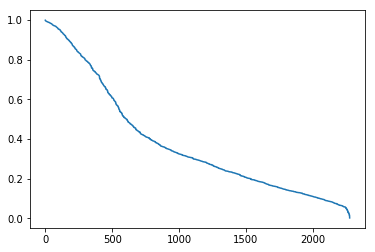

In [195]:
plt.plot(roc_curve(y_true, y_pred)[2])

In [202]:
import seaborn

Text(0,0.5,'$p_5$')

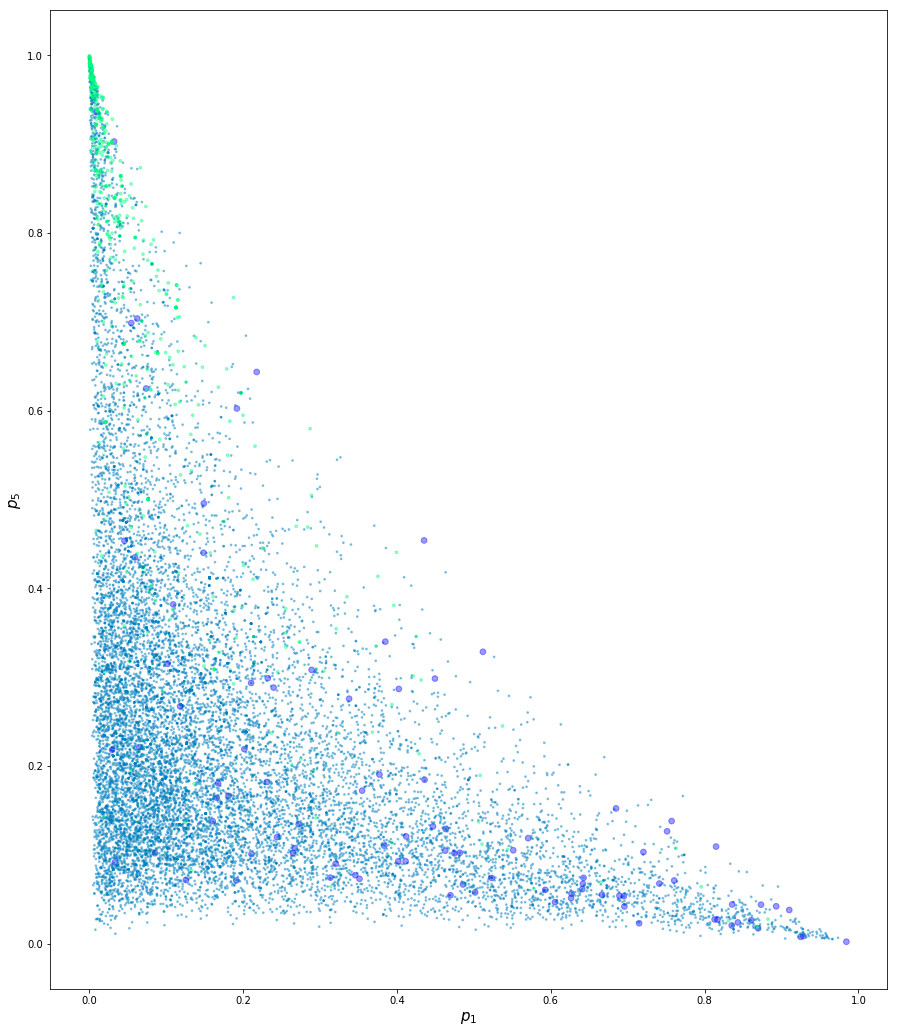

In [34]:
data = pd.DataFrame({'p1':scores_np[:, 0], 'p3':scores_np[:, 1], 'p5':scores_np[:, 2], 'score':samples.score.values})
plt.figure(figsize=(15, 18))
size = [3 + 30 * (x == 1) + 5 * (x == 5) for x in data.score]
plt.scatter(data.p1, data.p5, c=data.score, s=size, alpha=0.4, cmap='winter')
plt.xlabel('$p_1$', fontsize=15)
plt.ylabel('$p_5$', fontsize=15)


In [7]:
x = np.array([2, 3])
y = x.copy()

In [8]:
y[0] = 10
print(x)

[2 3]


In [13]:
x = {'1':1, '2':2}
y = x#.copy()


In [14]:
y['1'] = 100
print(x)

{'1': 100, '2': 2}


In [35]:
iterable = [1,2,3,4,5,6,7]

In [37]:
[iter(iterable)] * 5

In [39]:
def _grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

In [42]:
for x in _grouper(np.arange(101), 5):
    print(x)

(0, 1, 2, 3, 4)
(5, 6, 7, 8, 9)
(10, 11, 12, 13, 14)
(15, 16, 17, 18, 19)
(20, 21, 22, 23, 24)
(25, 26, 27, 28, 29)
(30, 31, 32, 33, 34)
(35, 36, 37, 38, 39)
(40, 41, 42, 43, 44)
(45, 46, 47, 48, 49)
(50, 51, 52, 53, 54)
(55, 56, 57, 58, 59)
(60, 61, 62, 63, 64)
(65, 66, 67, 68, 69)
(70, 71, 72, 73, 74)
(75, 76, 77, 78, 79)
(80, 81, 82, 83, 84)
(85, 86, 87, 88, 89)
(90, 91, 92, 93, 94)
(95, 96, 97, 98, 99)
(100, None, None, None, None)
